In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import cv2
import os

# --------------------
# CONFIG
# --------------------
model_path = "/home/debasish/Documents/YOLOv8/weights/pose-weights/yolov8x-832.pt"
video_input = Path("/home/debasish/Documents/YOLOv8/videos/image052.mp4")  # can be a single file OR a folder
timestep = 30.0  # for velocity calculation
output_base_dir = Path("outputs/area")
output_base_dir.mkdir(parents=True, exist_ok=True)

# --------------------
# Collect list of videos
# --------------------
video_extensions = [".mp4", ".avi", ".mov", ".mkv"]

if video_input.is_file() and video_input.suffix.lower() in video_extensions:
    video_files = [video_input]   # single video
elif video_input.is_dir():
    video_files = []
    for ext in video_extensions:
        video_files.extend(video_input.glob(f"*{ext}"))
    video_files = sorted(video_files)
else:
    raise ValueError(f"Input must be a video file ({video_extensions}) or a folder containing such files")

if not video_files:
    raise FileNotFoundError(f"No supported video files found in {video_input}")

# --------------------
# Process videos
# --------------------
for video_path in video_files:
    print(f"\nProcessing video: {video_path.name}")

    # Setup output folder for this video
    existing_runs = [d for d in output_base_dir.iterdir() if d.is_dir() and d.name.startswith("run")]
    run_num = len(existing_runs) + 1
    run_dir = output_base_dir / f"run{run_num}"
    run_dir.mkdir(parents=True, exist_ok=True)

    out_video_path = run_dir / f"{video_path.stem}.avi"
    out_csv_path = run_dir / f"{video_path.stem}_positions.csv"
    area_csv_path = run_dir / f"{video_path.stem}_outputs.csv"

    # --------------------
    # Initialize tracking variables per video
    # --------------------
    frame_num = 0
    frames, obj_ids, obj_clss, x, y, w, h = [], [], [], [], [], [], []
    trajectories = {}  # worm_id -> list of (x, y)
    worm_colors = {}
    id_mapping = {}  # old_id -> new_id
    next_id = 1      # restart from 1 for each video

    # --------------------
    # Load Model for each video (resets tracker IDs)
    # --------------------
    model = YOLO(model_path)

    # --------------------
    # Video reader & writer setup
    # --------------------
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        raise RuntimeError(f"Failed to open VideoWriter: {out_video_path}")

    # --------------------
    # Process frames
    # --------------------
    while True:
        ret, frame_img = cap.read()
        if not ret:
            break

        frame_num += 1
        results = model.track(frame_img, persist=True, tracker="bytetrack.yaml", conf=0.8)

        if results[0].boxes is None:
            writer.write(frame_img)
            continue

        boxes = results[0].boxes.cpu().numpy()
        if boxes is None or len(boxes) == 0 or boxes.cls is None or boxes.id is None or boxes.xywh is None:
            writer.write(frame_img)
            continue

        obj_cls = boxes.cls
        obj_id = boxes.id
        xywh = boxes.xywh

        # Map IDs consistently across frames in this video
        for old_id in obj_id:
            if old_id not in id_mapping:
                id_mapping[old_id] = next_id
                next_id += 1

        for i, j, k in zip(obj_cls, obj_id, xywh):
            obj_id_int = int(id_mapping[j])  # mapped ID starting from 1
            frames.append(frame_num)
            obj_clss.append(int(i))
            obj_ids.append(obj_id_int)
            x.append(k[0]); y.append(k[1]); w.append(k[2]); h.append(k[3])

            # Update trajectories and assign unique color
            if obj_id_int not in trajectories:
                trajectories[obj_id_int] = []
                worm_colors[obj_id_int] = tuple(np.random.randint(0, 255, size=3).tolist())
            trajectories[obj_id_int].append((int(k[0]), int(k[1])))

        # Draw trajectories
        for worm_id, points in trajectories.items():
            color = worm_colors[worm_id]
            for pt_idx in range(1, len(points)):
                cv2.line(frame_img, points[pt_idx-1], points[pt_idx], color=color, thickness=2)
            if len(points) > 0:
                last_point = points[-1]
                cv2.putText(frame_img, str(worm_id), (last_point[0]+5, last_point[1]-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        writer.write(frame_img)

    cap.release()
    writer.release()
    print(f"Tracked video saved at: {out_video_path}")

    # --------------------
    # Save coordinates CSV
    # --------------------
    data = {"frame": frames, "obj_cls": obj_clss, "obj_id": obj_ids}
    bbox_out = {"x": x, "y": y, "w": w, "h": h}
    coords_df = pd.concat([pd.DataFrame(data), pd.DataFrame(bbox_out)], axis=1)
    coords_df.to_csv(out_csv_path, index=False)
    print(f"Coordinates CSV saved: {out_csv_path}")

    # --------------------
    # Calculate distances, velocities, and area
    # --------------------
    worm_ids = sorted(coords_df["obj_id"].unique())
    distances, velocities, areas = [], [], []

    for worm_id in worm_ids:
        df_w = coords_df[coords_df["obj_id"] == worm_id]
        x_vals = df_w["x"].values
        y_vals = df_w["y"].values

        if len(x_vals) < 2:
            distances.append(0)
            velocities.append(0)
            areas.append(0)
            continue

        # Distance traveled
        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        distance = np.sum(np.sqrt(dx**2 + dy**2))
        velocity = distance / timestep

        # Area of movement (using bounding box diagonal)
        x_proj = np.max(x_vals) - np.min(x_vals)
        y_proj = np.max(y_vals) - np.min(y_vals)
        area = np.sqrt(x_proj**2 + y_proj**2)

        distances.append(distance)
        velocities.append(velocity)
        areas.append(area)

    # Save summary CSV
    track_outputs = pd.DataFrame({
        "worm_id": worm_ids,
        "Distance (pixels)": distances,
        "Velocity (pixels/s)": velocities,
        "Area (pixels)": areas
    })
    track_outputs.to_csv(area_csv_path, index=False)
    print(f"Summary (distance, velocity, area) saved: {speed_csv_path}")


Processing video: image052.mp4

0: 480x832 9 worms, 21.3ms
Speed: 1.7ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 21.2ms
Speed: 1.6ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 21.2ms
Speed: 1.6ms preprocess, 21.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 22.3ms
Speed: 1.5ms preprocess, 22.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 832)

0: 480x832 9 worms, 20.7ms
Speed: 1.3ms preprocess, 20.7ms inference, 0.8ms postprocess per 

In [5]:
track_outputs

,worm_id,Distance (pixels),Velocity (pixels/s),Area (pixels)
0,1,396.139771,13.204659,46.441453
1,2,400.925171,13.364172,78.438508
2,3,281.672424,9.389081,48.519360
3,4,115.339050,3.844635,52.287683
4,5,624.443237,20.814775,544.518724
5,6,503.972534,16.799084,105.586476
6,7,216.320114,7.210670,67.782951
7,8,18.659637,0.621988,7.157299
8,9,375.481323,12.516044,190.779662
9,10,39.698170,1.323272,38.264196


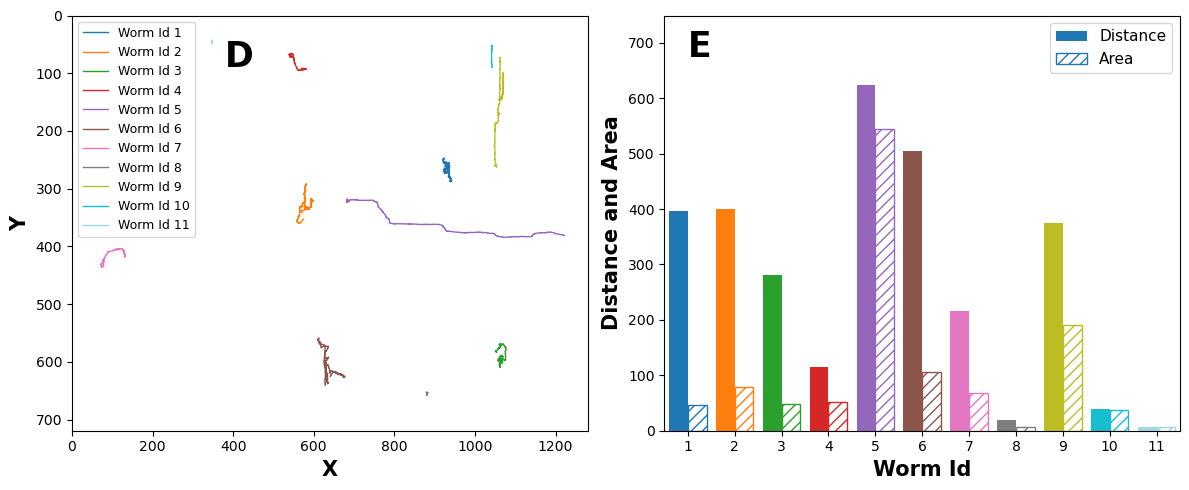

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

worm_ids = sorted(coords_df["obj_id"].unique())
frames = coords_df["frame"].unique()
N = len(frames)
t = 30.0

# -------------------
# Assign a unique color for each worm (consistent across plots)
# -------------------
colors = plt.cm.tab20(np.linspace(0, 1, len(worm_ids)))  # enough distinct colors
worm_colors = {worm_id: colors[i] for i, worm_id in enumerate(worm_ids)}

# -------------------
# Plot trajectories
# -------------------
for worm_id in worm_ids:
    df2 = coords_df.loc[coords_df["obj_id"] == worm_id]
    x = df2["x"].tolist()
    y = df2["y"].tolist()
    ax[0].plot(x, y, label=f"Worm Id {worm_id}", linewidth=1,
               color=worm_colors[worm_id])

ax[0].set_xlim(0, 1279)
ax[0].set_ylim(719, 0)
ax[0].set_xlabel('X', size=15, weight='bold')
ax[0].set_ylabel('Y', size=15, weight='bold')
ax[0].legend(ncols=1, fontsize=9)
ax[0].text(380, 90, "D", fontsize=25, weight='bold')

# -------------------
# Bar chart for Distance and Area
# -------------------
worm_id = track_outputs["worm_id"]
distance = track_outputs["Distance (pixels)"]
area = track_outputs["Area (pixels)"]

ind = np.arange(1, len(worm_id) + 1)
width = 0.4

# Distance bars (filled color)
ax[1].bar(ind - width/2, distance, width,
          color=[worm_colors[i] for i in worm_id],
          label='Distance')

# Area bars (same color, but hatched pattern to distinguish)
ax[1].bar(ind + width/2, area, width,
          facecolor='none', edgecolor=[worm_colors[i] for i in worm_id],
          hatch='///', label='Area')

ax[1].set_ylabel('Distance and Area', size=15, weight='bold')
ax[1].set_xlabel('Worm Id', color='black', size=15, weight='bold')
ax[1].set_ylim(0, max(max(distance), max(area)) * 1.2)
ax[1].set_xlim(0.5, len(worm_id) + 0.5)

ax[1].set_xticks(ind)
ax[1].set_xticklabels([str(i) for i in worm_id])
ax[1].legend(fontsize=11)
ax[1].text(1, ax[1].get_ylim()[1] * 0.9, "E", fontsize=25, weight='bold')

plt.tight_layout()
plt.show()